In [1]:
import yt
from matplotlib import rc_context
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib
unit_base={"length_unit": (1.0,"pc"), "time_unit": (1.0,"s*pc/km"), "mass_unit": (2.38858753789e-24,"g/cm**3*pc**3")}
matplotlib.get_backend()
matplotlib.use('TkAgg')
matplotlib.get_backend()

'TkAgg'

In [2]:
ds = yt.load("kh_custom.out1.00020.athdf", units_override=unit_base)
ds.field_list

yt : [WARNING  ] 2024-10-12 19:46:41,005 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2024-10-12 19:46:41,005 Overriding length_unit: 1.0 pc.
yt : [INFO     ] 2024-10-12 19:46:41,006 Overriding time_unit: 1.0 pc*s/km.
yt : [INFO     ] 2024-10-12 19:46:41,007 Overriding mass_unit: 2.38858753789e-24 g*pc**3/cm**3.
yt : [WARNING  ] 2024-10-12 19:46:41,008 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-10-12 19:46:41,053 Parameters: current_time              = 0.20001386
yt : [INFO     ] 2024-10-12 19:46:41,054 Parameters: domain_dimensions         = [2048 1024    1]
yt : [INFO     ] 2024-10-12 19:46:41,054 Parameters: domain_left_edge          = [-6.  -3.  -0.5]
yt : [INFO     ] 2024-10-12 19:46:41,054 Parameters: domain_right_edge         = [6.  3.  0.5]
yt : [INFO     ] 2024-10-12 19:46:41,055 Parameters: cosmological_simulation   = 0


[('athena_pp', 'Bcc1'),
 ('athena_pp', 'Bcc2'),
 ('athena_pp', 'Bcc3'),
 ('athena_pp', 'press'),
 ('athena_pp', 'rho'),
 ('athena_pp', 'vel1'),
 ('athena_pp', 'vel2'),
 ('athena_pp', 'vel3')]

In [54]:
frb = yt.FixedResolutionBuffer(ds.slice('z', 0), (-6, 6, -3, 3), (2048, 1024))

In [3]:
slc = ds.slice('z', 0)
slc['athena_pp', 'rho'].d
plt.imshow(slc['athena_pp', 'rho'].d.reshape(1024, 2048))
plt.show()
plt.imshow(frb['athena_pp', 'rho'].d)
plt.show()
print(slc.get_data(fields=('athena_pp', 'rho')))
# frb['density'].d.shape

2024-10-12 19:46:47.703 python[43521:3607665] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-12 19:46:47.703 python[43521:3607665] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


NameError: name 'frb' is not defined

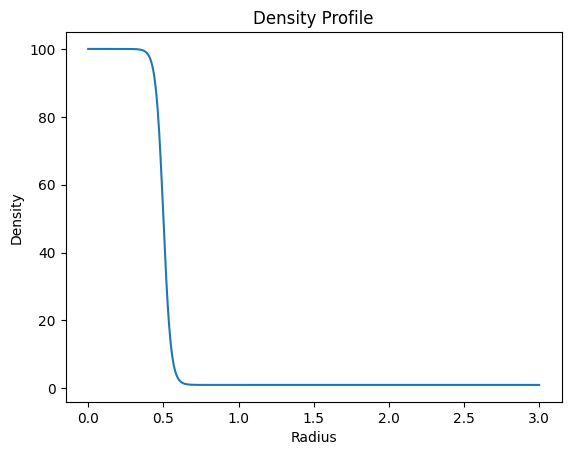

np.float64(1.0)

In [13]:
rho_0 = 1
density_contrast = 100
smoothing_thickness = 0.05
r = np.linspace(0, 3, 1000)
radius = 0.5

def density(r):
    return rho_0* ((density_contrast/2) + 0.5 + (density_contrast-1.0) * 0.5 * -np.tanh((r-radius)/smoothing_thickness) )

plt.title("Density Profile")
plt.xlabel("Radius")
plt.ylabel("Density")
plt.plot(r, density(r))
plt.show() 
density(3)

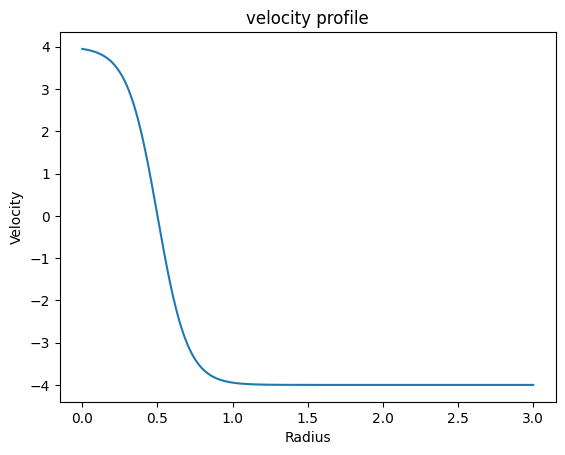

In [15]:
vel_shear = 4
smoothing_thickness_vel = 0.2

def velocity(r):
    return vel_shear * -1 * (np.tanh((r-radius)/smoothing_thickness_vel) )


plt.title("velocity profile")
plt.xlabel("Radius")
plt.ylabel("Velocity")
plt.plot(r, velocity(r))

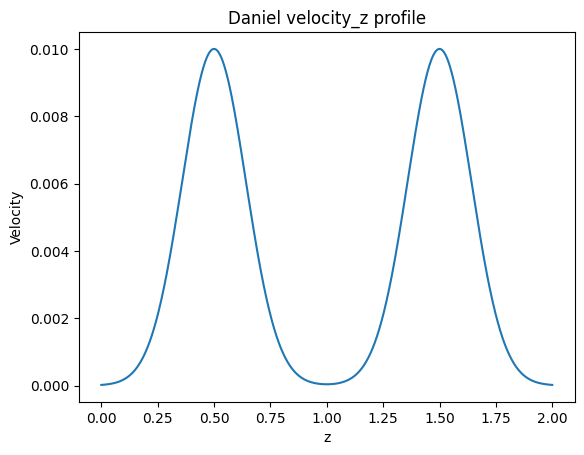

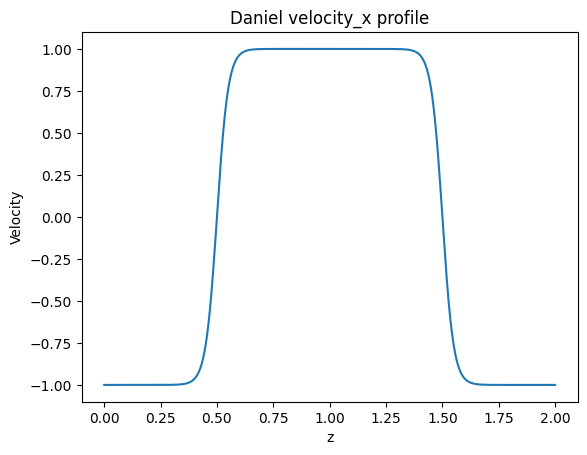

In [5]:
z = np.linspace(0, 2, 1000)
z1 = 0.5
z2 = 1.5
A = 0.01
x = 0.25
pert = A*np.sin(2*np.pi*x)
sigma = 0.2
a = 0.05
u_flow = 1

def vel_x(z):
    return u_flow * (np.tanh((z-z1)/a) - np.tanh((z-z2)/a) - 1)

def vel_z(z):
    return pert * (np.exp(-((z-z1)/sigma)**2)+np.exp(-((z-z2)/sigma)**2))

plt.title("Daniel velocity_z profile")
plt.xlabel("z")
plt.ylabel("Velocity")
plt.plot(z, vel_z(z))
plt.show()

plt.title("Daniel velocity_x profile")
plt.xlabel("z")
plt.ylabel("Velocity")
plt.plot(z, vel_x(z))
plt.show()

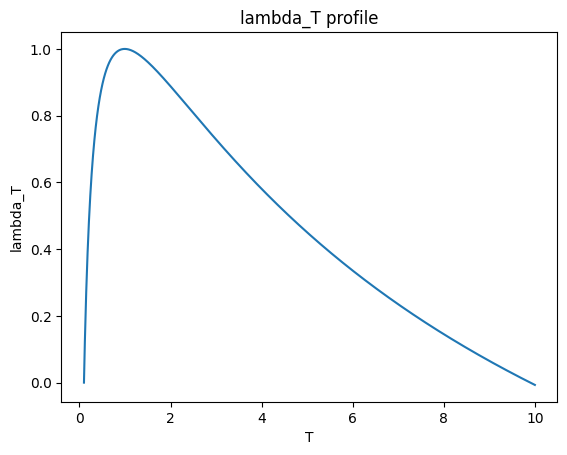

np.float64(0.5010935880000178)

In [14]:
T_cold = 0.1
T_hot = 10
T = np.linspace(0.1, 10, 1000)
def lambda_T(T):
    return np.sin(np.pi*np.log(T/T_cold) / (np.log((T_hot-T_cold)/T_cold)))

plt.title("lambda_T profile")
plt.xlabel("T")
plt.ylabel("lambda_T")
plt.plot(T, lambda_T(T))
plt.show()
lambda_T(1)

In [ ]:
def test(x):
    return np.cos(x) - np.cos(3*x)

x = 